In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate as interp
import numpy as np

In [2]:
%matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [3]:
mpl.rcParams['figure.dpi'] = 100

In [4]:
def entropy_ideal_gas(rho, T, rho0, T0, s0, mu=2.3, gamma=5.0/3.0):
    # s0 = s(rho0, T0) has to be consistent
    kB = 1.38e-16  # erg/K
    m_H = 1.67e-24 # g
    return kB/(mu*m_H)*(1.0/(gamma-1.0)*np.log(T/T0) - np.log(rho/rho0)) + s0

In [5]:
def read_eos_table_dt(filename, delimiter=None):
    data = np.loadtxt(filename, delimiter=delimiter) 

    logT_table   = data[:, 0]
    logrho_table = data[:, 1]
    logP_table   = data[:, 2]
    logu_table   = data[:, 3]
    logs_table   = data[:, 4]

    # All the SCvH EOS tables are tabulated along isotherms
    logT = np.unique(logT_table)
    nT = np.size(logT)

    # For the mixture tables the number of grid points in rho the same for each isotherm
    nRho = int(np.size(logT_table)/nT)
    
    print("nT = {:} nRho = {:}".format(nT, nRho))
    
    logrho = logrho_table[0:nRho]
    
    logrho_min = np.min(logrho)
    logrho_max = np.max(logrho)
    logT_min   = np.min(logT)
    logT_max   = np.max(logT)

    print("logrho_min = {:}".format(logrho_min))
    print("logrho_max = {:}".format(logrho_max))
    print("logT_min   = {:}".format(logT_min))
    print("logT_max   = {:}".format(logT_max))
    print()

    # Split into arrays of constant T
    logP_array = np.split(logP_table, nT)
    logu_array = np.split(logu_table, nT)
    logs_array = np.split(logs_table, nT)

    # Generate 2d arrays
    logP = np.vstack(logP_array)
    logu = np.vstack(logu_array)
    logs = np.vstack(logs_array)
      
    eos_table_dt = {
        "nT":         nT,
        "nRho":       nRho,
        "logT":       logT,
        "logrho":     logrho,
        "logrho_min": logrho_min,
        "logrho_max": logrho_max,
        "logT_min":   logT_min,
        "logT_max":   logT_max,
        "logP":       logP,
        "logu":       logu,
        "logs":       logs,
    }
    
    return eos_table_dt

In [6]:
# Write an EOS table to an output file.
def write_eos_table(output_file, logrho_axis, logT_axis, logP_array, logu_array, logs_array, delimiter=" ", comments="#", input_file=""):
    nRho = np.size(logrho_axis)
    nT = np.size(logT_axis)
    
    # Store the different isotherms in 1d arrays
    logrho = np.tile(logrho_axis, nT)
    logT = np.repeat(logT_axis, nRho)

    logP = logP_array.flatten(order='C')
    logu = logu_array.flatten(order='C')
    logs = logs_array.flatten(order='C')
    
    header = " nT = {:} nRho= {:} (input file: {:})\n"\
             " {:} {:} {:} {:} {:}".format(nT, nRho, input_file, "logT [K]", "logRho [g/cc]", "logP [barye]", "logE [erg/g]", "logS [erg/g/K]")
    
    np.savetxt(output_file, np.column_stack([logT, logrho, logP, logu, logs]), header=header, fmt='%.8e', delimiter=delimiter, comments=comments)
    

In [7]:
scvh_ext_dt = read_eos_table_dt("scvh_extended_dt_hydrogen_722_helium_278.data")

# At logT = 2.1 the SCvH EOS table starts
index_start_scvh = np.min(np.where(scvh_ext_dt['logT'] >= 2.1)[0])

print("The SCvH EOS starts from index: {:}".format(index_start_scvh))

nT = 76 nRho = 460
logrho_min = -20.0
logrho_max = 2.95
logT_min   = 1.06
logT_max   = 7.06

The SCvH EOS starts from index: 13


In [8]:
# Load the limits of the original table in P-T
data = np.loadtxt("logrho_limit_pt.txt")

logT_limit = data[:,0]
logrho_limit_min = data[:,1]
logrho_limit_max = data[:,2]

Text(0.5, 1.0, 'Pressure')

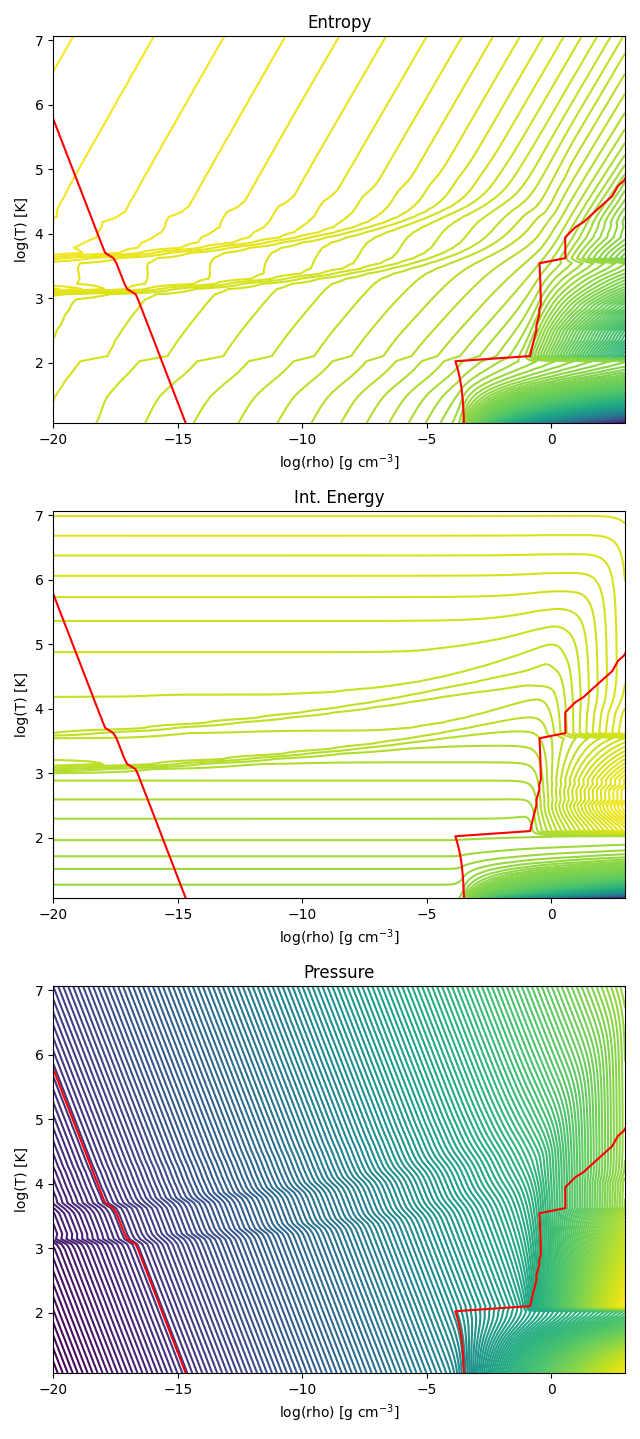

In [9]:
# Plot log(P), log(u) and log(s)
fig, ax = plt.subplots(3, 1)

x, y = fig.get_size_inches()
fig.set_size_inches(1*x, 3*y)

fig.set_tight_layout(True)

#levels = np.linspace(scvh_ext_dt['logrho_min'], scvh_ext_dt['logrho_max'], 101)
#levels = np.sort(levels)

# Entropy
#ax.contour(scvh_ext_dt['logrho'], scvh_ext_dt['logT'], scvh_ext_dt['logs'], levels)
ax[0].contour(scvh_ext_dt['logrho'], scvh_ext_dt['logT'], scvh_ext_dt['logs'], levels=200)

ax[0].plot(logrho_limit_min, logT_limit, color='red')
ax[0].plot(logrho_limit_max, logT_limit, color='red')

ax[0].set_xlim(scvh_ext_dt['logrho_min'], scvh_ext_dt['logrho_max'])
ax[0].set_ylim(scvh_ext_dt['logT_min'], scvh_ext_dt['logT_max'])

ax[0].set(xlabel="log(rho) [g cm$^{-3}$]", ylabel="log(T) [K]")
ax[0].set_title("Entropy")

# Internal energy
ax[1].contour(scvh_ext_dt['logrho'], scvh_ext_dt['logT'], scvh_ext_dt['logu'], levels=200)

ax[1].plot(logrho_limit_min, logT_limit, color='red')
ax[1].plot(logrho_limit_max, logT_limit, color='red')

ax[1].set_xlim(scvh_ext_dt['logrho_min'], scvh_ext_dt['logrho_max'])
ax[1].set_ylim(scvh_ext_dt['logT_min'], scvh_ext_dt['logT_max'])

ax[1].set(xlabel="log(rho) [g cm$^{-3}$]", ylabel="log(T) [K]")
ax[1].set_title("Int. Energy")

# Pressure
ax[2].contour(scvh_ext_dt['logrho'], scvh_ext_dt['logT'], scvh_ext_dt['logP'], levels=200)

ax[2].plot(logrho_limit_min, logT_limit, color='red')
ax[2].plot(logrho_limit_max, logT_limit, color='red')

ax[2].set_xlim(scvh_ext_dt['logrho_min'], scvh_ext_dt['logrho_max'])
ax[2].set_ylim(scvh_ext_dt['logT_min'], scvh_ext_dt['logT_max'])

ax[2].set(xlabel="log(rho) [g cm$^{-3}$]", ylabel="log(T) [K]")
ax[2].set_title("Pressure")


    
#for logT in scvh_ext_dt['logT']:
#    ax.scatter(scvh_ext_dt['logrho'], np.ones(scvh_ext_dt['nRho'])*logT, s=1)

In [21]:
# Try to extend the table to low T with an ideal gas using one reference entropy for the whole table
logs_shifted = np.copy(scvh_ext_dt['logs'])

# Calculate reference point s0
index_logrho0 = np.min(np.where(scvh_ext_dt['logrho'] >= -13)[0])
index_logT0 = index_start_scvh

logrho0 = scvh_ext_dt['logrho'][index_logrho0]
logT0 = scvh_ext_dt['logT'][index_logT0]

logs0 = scvh_ext_dt['logs'][index_logT0, index_logrho0]

print("Reference point: logs0 = {:} logrho0 = {:} (iRho= {:}) logT0 = {:} (iT= {:})".format(logs0, logrho0, index_logrho0, logT0, index_logT0))

T0 = 10.0**logT0
rho0 = 10**logrho0
s0 = 10.0**logs0

print("s0= {:} rho0= {:} T0= {:}".format(s0, rho0, T0))

for i in range(index_start_scvh):
    T = 10.0**scvh_ext_dt['logT'][i]
    rho = 10.0**scvh_ext_dt['logrho']

    logs_shifted[i,:] = np.log10(entropy_ideal_gas(rho, T, rho0, T0, s0, mu=2.3, gamma=1.4))

Reference point: logs0 = 9.1151064 logrho0 = -13.0 (iRho= 140) logT0 = 2.1 (iT= 13)
s0= 1303486086.9803283 rho0= 1e-13 T0= 125.89254117941675


/tmp/ipykernel_624985/976152406.py:25: RuntimeWarning: invalid value encountered in log10
  logs_shifted[i,:] = np.log10(entropy_ideal_gas(rho, T, rho0, T0, s0, mu=2.3, gamma=1.4))


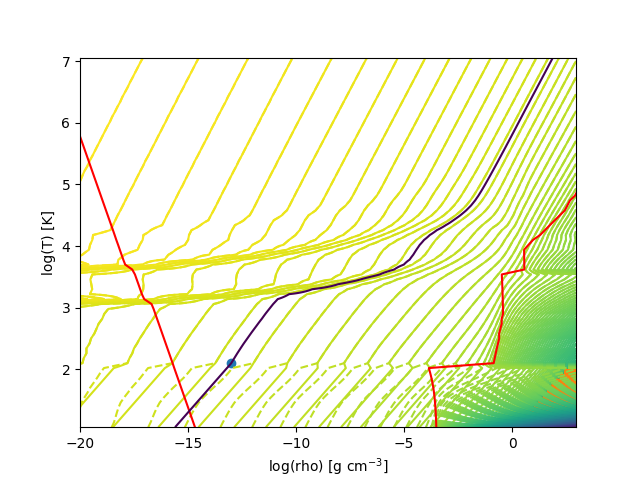

In [22]:
# Plot isentropes
fig, ax = plt.subplots(1, 1)

levels = np.linspace(np.amin(scvh_ext_dt['logs']), np.amax(scvh_ext_dt['logs']), 201)
levels = np.sort(levels)

ax.contour(scvh_ext_dt['logrho'], scvh_ext_dt['logT'], logs_shifted, levels=levels)
#ax.contour(scvh_ext_dt['logrho'], scvh_ext_dt['logT'], logs_shifted, levels=100)

#ax.contour(scvh_ext_dt['logrho'], scvh_ext_dt['logT'], scvh_ext_dt['logs'], levels=100, colors='green')
ax.contour(scvh_ext_dt['logrho'], scvh_ext_dt['logT'], scvh_ext_dt['logs'], levels=levels, linestyles='dashed')

# Show limits of the original table
ax.plot(logrho_limit_max, logT_limit, color='red')
ax.plot(logrho_limit_min, logT_limit, color='red')

ax.set_xlim(scvh_ext_dt['logrho_min'], scvh_ext_dt['logrho_max'])
ax.set_ylim(scvh_ext_dt['logT_min'], scvh_ext_dt['logT_max'])

ax.set(xlabel="log(rho) [g cm$^{-3}$]", ylabel="log(T) [K]")

# Show reference point
ax.scatter(logrho0, logT0)
ax.contour(scvh_ext_dt['logrho'], scvh_ext_dt['logT'], logs_shifted, [logs0])

# Show where logs is NaN
index_nan = np.where(np.isnan(logs_shifted) == True)

xx, yy = np.meshgrid(scvh_ext_dt['logrho'], scvh_ext_dt['logT'])
ax.scatter(xx[index_nan], yy[index_nan])

In [23]:
# Try to extend the table to low T with an ideal gas using different reference entropies s0 for each isochore
logs_shifted = np.copy(scvh_ext_dt['logs'])

verbose = False

for index_logrho0 in range(scvh_ext_dt['nRho']):
    # Calculate reference point s0 for each isotherm
    index_logT0 = index_start_scvh

    logrho0 = scvh_ext_dt['logrho'][index_logrho0]
    logT0 = scvh_ext_dt['logT'][index_logT0]

    logs0 = scvh_ext_dt['logs'][index_logT0, index_logrho0]

    if verbose is True:
        print("Reference point: logs0 = {:} logrho0 = {:} (iRho= {:}) logT0 = {:} (iT= {:})".format(logs0, logrho0, index_logrho0, logT0, index_logT0))

    T0 = 10.0**logT0
    rho0 = 10**logrho0
    s0 = 10.0**logs0

    T = 10.0**scvh_ext_dt['logT'][0:index_logT0]
    rho = 10.0**scvh_ext_dt['logrho'][index_logrho0]
    
    logs_of_rho = np.log10(entropy_ideal_gas(rho, T, rho0, T0, s0, mu=2.3, gamma=1.4))
    if np.any(np.isnan(logs_of_rho)):
        print("Invalid values found, skip logrho= {:}".format(np.log10(rho)))
    else:
        logs_shifted[0:index_logT0,index_logrho0] = np.log10(entropy_ideal_gas(rho, T, rho0, T0, s0, mu=2.3, gamma=1.4))

# Write corrected eos table
write_eos_table("scvh_extended_dt_hydrogen_722_helium_278.data_fixed_entropy", scvh_ext_dt['logrho'], scvh_ext_dt['logT'], scvh_ext_dt['logP'], scvh_ext_dt['logu'], logs_shifted, input_file="scvh_extended_dt_hydrogen_722_helium_278.data")


Invalid values found, skip logrho= -0.85
Invalid values found, skip logrho= -0.8
Invalid values found, skip logrho= -0.75
Invalid values found, skip logrho= -0.7
Invalid values found, skip logrho= -0.65
Invalid values found, skip logrho= -0.6
Invalid values found, skip logrho= -0.55
Invalid values found, skip logrho= -0.5
Invalid values found, skip logrho= -0.44999999999999996
Invalid values found, skip logrho= -0.4
Invalid values found, skip logrho= -0.35
Invalid values found, skip logrho= -0.30000000000000004
Invalid values found, skip logrho= -0.25
Invalid values found, skip logrho= -0.19999999999999998
Invalid values found, skip logrho= -0.15
Invalid values found, skip logrho= -0.1
Invalid values found, skip logrho= -0.04999999999999998
Invalid values found, skip logrho= 2.8418730439316076e-13
Invalid values found, skip logrho= 0.04999999999999996
Invalid values found, skip logrho= 0.10000000000000002
Invalid values found, skip logrho= 0.15000000000000002
Invalid values found, skip

/tmp/ipykernel_624985/2759915242.py:25: RuntimeWarning: invalid value encountered in log10
  logs_of_rho = np.log10(entropy_ideal_gas(rho, T, rho0, T0, s0, mu=2.3, gamma=1.4))


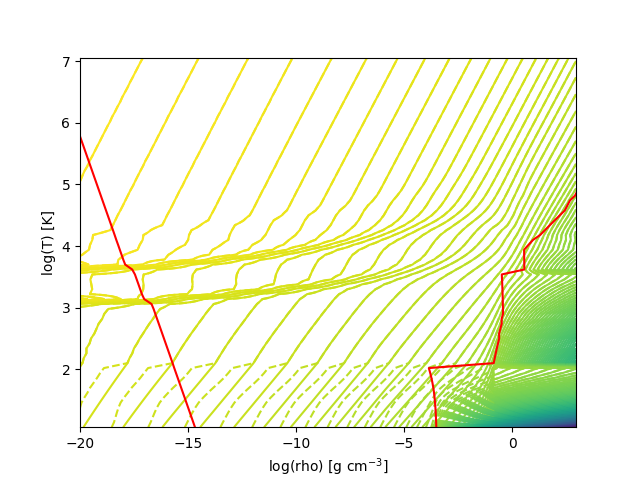

In [25]:
# Plot isentropes
fig, ax = plt.subplots(1, 1)

levels = np.linspace(np.amin(scvh_ext_dt['logs']), np.amax(scvh_ext_dt['logs']), 201)
levels = np.sort(levels)

ax.contour(scvh_ext_dt['logrho'], scvh_ext_dt['logT'], logs_shifted, levels=levels)
#ax.contour(scvh_ext_dt['logrho'], scvh_ext_dt['logT'], logs_shifted, levels=100)

#ax.contour(scvh_ext_dt['logrho'], scvh_ext_dt['logT'], scvh_ext_dt['logs'], levels=100, colors='green')
ax.contour(scvh_ext_dt['logrho'], scvh_ext_dt['logT'], scvh_ext_dt['logs'], levels=levels, linestyles='dashed')

# Show limits of the original table
ax.plot(logrho_limit_max, logT_limit, color='red')
ax.plot(logrho_limit_min, logT_limit, color='red')

ax.set_xlim(scvh_ext_dt['logrho_min'], scvh_ext_dt['logrho_max'])
ax.set_ylim(scvh_ext_dt['logT_min'], scvh_ext_dt['logT_max'])

ax.set(xlabel="log(rho) [g cm$^{-3}$]", ylabel="log(T) [K]")

# Show where logs is NaN
index_nan = np.where(np.isnan(logs_shifted) == True)

xx, yy = np.meshgrid(scvh_ext_dt['logrho'], scvh_ext_dt['logT'])
ax.scatter(xx[index_nan], yy[index_nan])

[Text(0.5, 0, 'log(T) [K]'), Text(0, 0.5, 'log(s) [erg g$^{-1}$ K$^{-1}$]')]

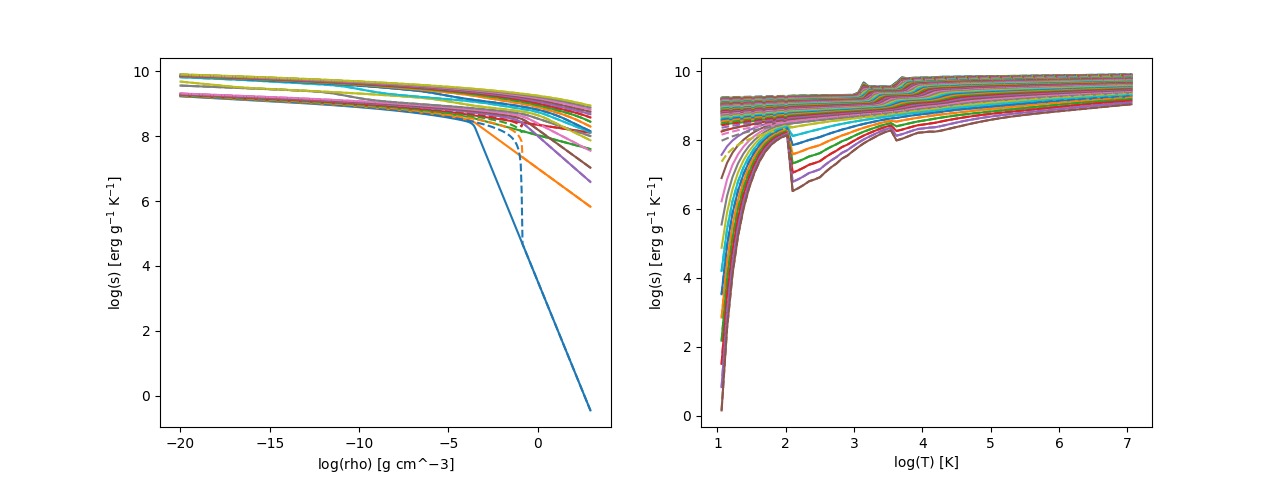

In [26]:
# Plot log(s) of the original and modified table
fig, ax = plt.subplots(1, 2)

x, y = fig.get_size_inches()

fig.set_size_inches(2*x, 1*y)

nSkipT = 4
nSkipRho = 10

# s(rho, T=const)
ax[0].set_prop_cycle(None)

for i in range(0, scvh_ext_dt['nT'], nSkipT):
    ax[0].plot(scvh_ext_dt['logrho'], scvh_ext_dt['logs'][i,:], '-')

ax[0].set_prop_cycle(None)

for i in range(0, scvh_ext_dt['nT'], nSkipT):
    ax[0].plot(scvh_ext_dt['logrho'], logs_shifted[i,:], '--')

    
ax[0].set(xlabel="log(rho) [g cm^${-3}$]", ylabel="log(s) [erg g$^{-1}$ K$^{-1}$]")

# s(rho=const, T)
ax[1].set_prop_cycle(None)

for i in range(0, scvh_ext_dt['nRho'], nSkipRho):
    ax[1].plot(scvh_ext_dt['logT'], scvh_ext_dt['logs'][:,i], '-')

ax[1].set_prop_cycle(None)

for i in range(0, scvh_ext_dt['nRho'], nSkipRho):
    ax[1].plot(scvh_ext_dt['logT'], logs_shifted[:,i], '--')

ax[1].set(xlabel="log(T) [K]", ylabel="log(s) [erg g$^{-1}$ K$^{-1}$]")


In [27]:
# Check if the old and the new table agree

scvh_old = read_eos_table_dt("scvh_extended_dt_hydrogen_722_helium_278.data")
scvh_new = read_eos_table_dt("scvh_extended_dt_hydrogen_722_helium_278.data_fixed_entropy")

if np.any(np.abs((scvh_old['logrho']-scvh_new['logrho'])/scvh_old['logrho']) > 1e-8):
    print("logrho axis differ.")

if np.any(np.abs((scvh_old['logT']-scvh_new['logT'])/scvh_old['logT']) > 1e-8):
    print("logT axis differ.")

if np.any(np.abs((scvh_old['logP']-scvh_new['logP'])/scvh_old['logP']) > 1e-8):
    print("logP axis differ.")
    
if np.any(np.abs((scvh_old['logu']-scvh_new['logu'])/scvh_old['logu']) > 1e-8):
    print("logu axis differ.")

if np.any(np.abs((scvh_old['logs']-scvh_new['logs'])/scvh_old['logs']) > 1e-8):
    print("logs axis differ.")
    
print(np.where(10.0**scvh_new['logs'] < 0.0))
print(np.where(10.0**scvh_new['logs'] < 0.0))

nT = 76 nRho = 460
logrho_min = -20.0
logrho_max = 2.95
logT_min   = 1.06
logT_max   = 7.06

nT = 76 nRho = 460
logrho_min = -20.0
logrho_max = 2.95
logT_min   = 1.06
logT_max   = 7.06

logs axis differ.
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


Text(0.5, 1.0, 'Entropy')

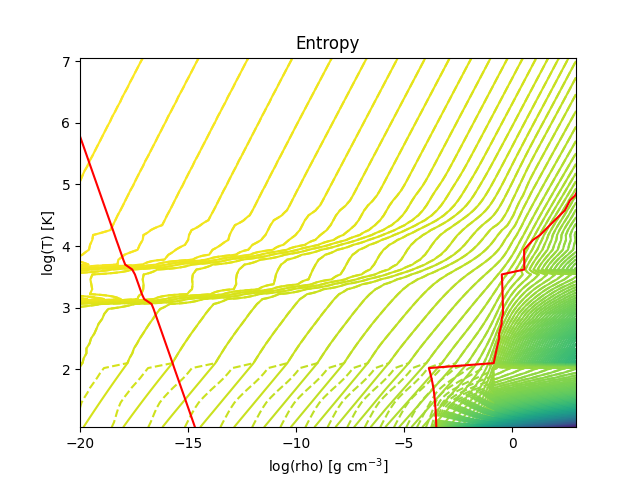

In [29]:
# Plot the old and new eos table
fig, ax = plt.subplots(1, 1)
    
levels = np.linspace(np.amin(scvh_ext_dt['logs']), np.amax(scvh_ext_dt['logs']), 201)
levels = np.sort(levels)

ax.contour(scvh_new['logrho'], scvh_new['logT'], scvh_new['logs'], levels=levels)
ax.contour(scvh_old['logrho'], scvh_old['logT'], scvh_old['logs'], levels=levels, linestyles='dashed')

# Show limits of the original table
ax.plot(logrho_limit_max, logT_limit, color='red')
ax.plot(logrho_limit_min, logT_limit, color='red')

ax.set_xlim(scvh_old['logrho_min'], scvh_old['logrho_max'])
ax.set_ylim(scvh_old['logT_min'], scvh_old['logT_max'])

ax.set(xlabel="log(rho) [g cm$^{-3}$]", ylabel="log(T) [K]")
ax.set_title("Entropy")

Text(0.5, 1.0, 'Pressure')

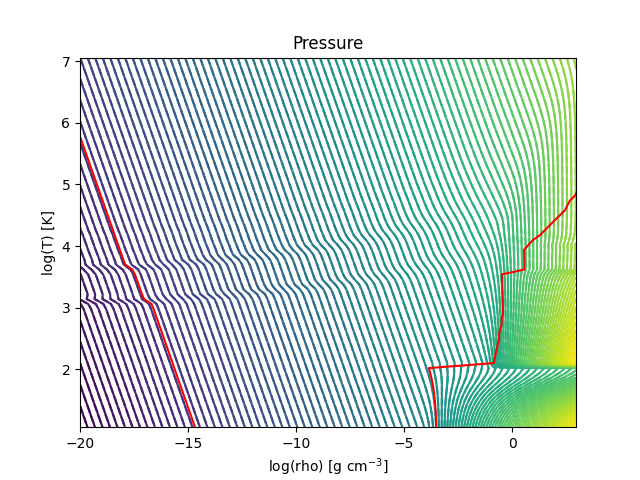

In [30]:
# Plot the old and new eos table
fig, ax = plt.subplots(1, 1)
    
levels = np.linspace(np.amin(scvh_ext_dt['logP']), np.amax(scvh_ext_dt['logP']), 101)
levels = np.sort(levels)

ax.contour(scvh_new['logrho'], scvh_new['logT'], scvh_new['logP'], levels=levels)
ax.contour(scvh_old['logrho'], scvh_old['logT'], scvh_old['logP'], levels=levels, linestyles='dashed')

# Show limits of the original table
ax.plot(logrho_limit_max, logT_limit, color='red')
ax.plot(logrho_limit_min, logT_limit, color='red')

ax.set_xlim(scvh_old['logrho_min'], scvh_old['logrho_max'])
ax.set_ylim(scvh_old['logT_min'], scvh_old['logT_max'])

ax.set(xlabel="log(rho) [g cm$^{-3}$]", ylabel="log(T) [K]")
ax.set_title("Pressure")

Text(0.5, 1.0, 'Int. energy')

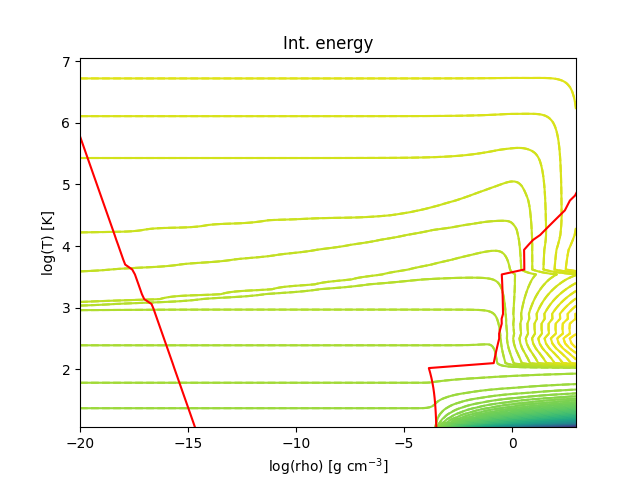

In [31]:
# Plot the old and new eos table
fig, ax = plt.subplots(1, 1)
    
levels = np.linspace(np.amin(scvh_ext_dt['logu']), np.amax(scvh_ext_dt['logu']), 101)
levels = np.sort(levels)

ax.contour(scvh_new['logrho'], scvh_new['logT'], scvh_new['logu'], levels=levels)
ax.contour(scvh_old['logrho'], scvh_old['logT'], scvh_old['logu'], levels=levels, linestyles='dashed')

# Show limits of the original table
ax.plot(logrho_limit_max, logT_limit, color='red')
ax.plot(logrho_limit_min, logT_limit, color='red')

ax.set_xlim(scvh_old['logrho_min'], scvh_old['logrho_max'])
ax.set_ylim(scvh_old['logT_min'], scvh_old['logT_max'])

ax.set(xlabel="log(rho) [g cm$^{-3}$]", ylabel="log(T) [K]")
ax.set_title("Int. energy")

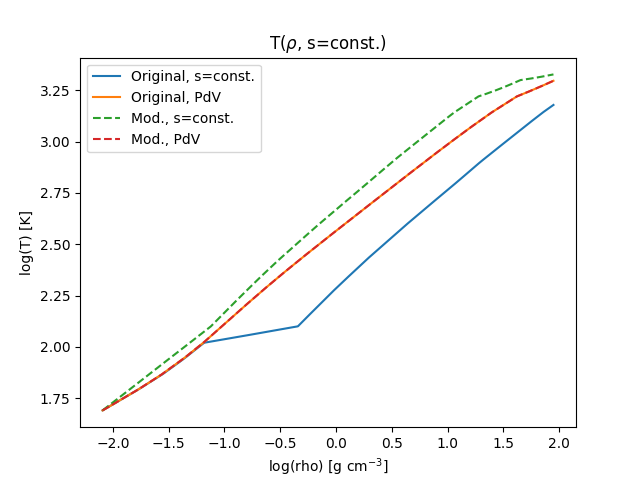

In [34]:
data1 = np.loadtxt("calc_isentrope_logrhologt.txt")

logrho   = data1[:,0]
logT     = data1[:,1]
logT_PdV = data1[:,5]

data2 = np.loadtxt("calc_isentrope_logrhologt_mod.txt")

logrho_m   = data2[:,0]
logT_m     = data2[:,1]
logT_PdV_m = data2[:,5]


fig, ax = plt.subplots(1, 1)

#ax.set_prop_cycle(None)
ax.plot(logrho, logT, label="Original, s=const.")
ax.plot(logrho, logT_PdV, label="Original, PdV")

#ax.set_prop_cycle(None)
ax.plot(logrho_m, logT_m, '--', label="Mod., s=const.")
ax.plot(logrho_m, logT_PdV_m, '--', label="Mod., PdV")


ax.set(xlabel="log(rho) [g cm$^{-3}$]", ylabel="log(T) [K]")
ax.set_title(r"T($\rho$, s=const.)")
ax.legend()
